# Volatility smile and model calibration


## Contents
   - [How to produce the smile?](#sec1)
       - [Implied volatility](#sec1.1)
       - [Lewis representation](#sec1.2)
   - [Market data](#sec2)
       - [1 week maturity](#sec2.1)
       - [6 months maturity](#sec2.2)
       
       
       
In this notebook, we discuss in a very **basic and naive** way the implied volatility of options.

The **Implied Volatility** is that value $\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:

$$ BS\;(S, K, T, r, \sigma) = P  $$

where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.     
The only **non observable** quantity is $\sigma$.
However, since BS is an increasing continuous function of $\sigma$, there is a one-one correspondence 

$$\sigma \longleftrightarrow BS\;(S, K, T, r, \sigma)$$

where all the other variables are kept fixed.    
For this reasons, it is common to quote option market prices in terms of implied volatilities.

According to the assumptions of the Black-Scholes model, the stock price follows a Geometric Brownian Motion and the implied volatility (IV) should be the same for all $K$, $T$. 
In practice, however, it depends on both. This relation $\sigma(K, T)$ is called a **volatility surface**.    
The dependence of IV on $T$ is called **term structure**, while the dependece on $K$ is called **volatility smile**.
In this notebook I will consider only the volatility smile.

But... why does the volatility change for different $K$ and $T$?        
The sad truth is that the Geometric Brownian Motion is not a good model to describe the underlying dynamics!

And here there are plenty of nice quotes to recall such as: 

> *"Essentially, all models are wrong, but some are useful".* [George Box](https://en.wikipedia.org/wiki/All_models_are_wrong)

> *"The implied volatility is the wrong number to put in the wrong formula to obtain the right price".* Riccardo Rebonato [1]

Some models (still wrong, but more useful) that better replicate the price dynamics, and under an appropriate risk neutral measure, are able to reproduce the volatility surface are:
1. Local volatility models:  $ dS_t = \mu S_t dt + S_t \sigma(t, S_t) dW_t $. 

2. Stochastic volatility models, e.g. Heston model.

3. Exponential or Geometric Lévy processes, e.g. Merton Jump-Diffusion model, NIG, Variance Gamma.

4. Combination of stochastic volatility and jumps, e.g. [Bates model](https://en.wikipedia.org/wiki/Stochastic_volatility_jump). These type of models are the best for this purpose (see [2]). The reason is that they describe better the empirical features of the prices, such as volatility clustering and jumps. 
The presence of many parameters makes these models much more flexible.

Here I consider only the case of stochastic volatility and Lévy processes, since I have already introduced them in the notebooks **1.4** and **1.5**.

When considering complex models, it is very difficult to pass from the physical measure to the correct risk neutral measure (which is not unique).
For this reason, the best approach is to derive the model parameters directly from the prices (usually European call and put options with different strikes and maturities) 
already quoted in the market.
The process of choosing the risk neutral parameters for a model, such that it reproduces the prices in the market is called **model calibration**.

In [1]:
from functions.Parameters import Option_param
from functions.Processes import Diffusion_process, Merton_process, VG_process, Heston_process
from functions.BS_pricer import BS_pricer
from functions.Merton_pricer import Merton_pricer 
from functions.VG_pricer import VG_pricer
from functions.Heston_pricer import Heston_pricer

import numpy as np
import pandas as pd
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.optimize as scpo
from functools import partial
from itertools import compress
import os
import warnings
warnings.filterwarnings("ignore")

<a id='sec1'></a>
# How to produce the smile?


Alright... Let us check if the "complex models" mentioned above, are able to reproduce the volatility smile!

In the following cell, I'm going to create the objects for the **Black-Scholes, Merton, Variance Gamma and Heston** pricers. I chose the values of the process parameters such that the processes have similar variance.    
The option is a European call with strike $K=100$, and maturity $T=1$. We will see below that changing the time to maturity can create problems.

The notation is the same I used in the other notebooks. If you have forgotten it, check the *doc*:    
You can type `Heston_param.__doc__` or `Heston_param??` in a cell.

In [2]:
T = 1
S0 = 100; K = 100
opt_param = Option_param(S0=S0, K=K, T=T, v0=0.04, exercise="European", payoff="call" )

diff_param = Diffusion_process(r=0.1, sig=0.2)
Merton_param = Merton_process(r=0.1, sig=0.1, lam=0.8, muJ=-0.04, sigJ=0.2)
VG_param = VG_process(r=0.1, theta=-0.09, sigma=0.19, kappa=0.6)
Heston_param = Heston_process(mu=0.1, rho=-0.3, sigma=0.6, theta=0.04, kappa=5)

BS = BS_pricer(opt_param, diff_param)
VG = VG_pricer(opt_param, VG_param)
Mert = Merton_pricer(opt_param, Merton_param)
Hest = Heston_pricer(opt_param, Heston_param)

Let us create a grid of strikes $[50, 55, ..., 145, 150]$, and compute the option prices.    
In this case, the best approach is to use the Fourier Transform method described in the notebook **1.4**.     
**This method is super fast!!**

In [3]:
strikes = np.arange(50,151,5)    # strike grid
BS_prices = BS.FFT(strikes)
Mert_prices = Mert.FFT(strikes)
Hest_prices = Hest.FFT(strikes)
VG_prices = VG.FFT(strikes)

Well... if there is a closed formula, why not use it?   

The closed formula is always the best solution, but the FFT method is very fast and has a small error. You won't notice the difference.

For VG and Heston there is no closed formula. A possible alternative is to use the Fourier inversion method. 

Let's see how small is the error:

In [4]:
# Closed formula prices
BS_prices_cl = np.zeros_like(strikes, dtype=float)
VG_prices_cl = np.zeros_like(strikes, dtype=float)
Mert_prices_cl = np.zeros_like(strikes, dtype=float)
Hest_prices_cl = np.zeros_like(strikes, dtype=float)

for i,K in enumerate(strikes):
    BS.K = K; VG.K = K; Mert.K = K; Hest.K = K
    BS_prices_cl[i] = BS.closed_formula()  
    VG_prices_cl[i] = VG.Fourier_inversion()  
    Mert_prices_cl[i] = Mert.closed_formula() 
    Hest_prices_cl[i] = Hest.Fourier_inversion() 

In [5]:
print("Closed vs FFT. Total absolute error BS: ", np.linalg.norm(BS_prices-BS_prices_cl,1) )
print("Closed vs FFT. Total absolute error VG: ", np.linalg.norm(VG_prices-VG_prices_cl,1) )
print("Closed vs FFT. Total absolute error Merton: ", np.linalg.norm(Mert_prices-Mert_prices_cl,1) )
print("Closed vs FFT. Total absolute error Heston: ", np.linalg.norm(Hest_prices-Hest_prices_cl,1) )

Closed vs FFT. Total absolute error BS:  1.2537768903086999e-06
Closed vs FFT. Total absolute error VG:  3.1493056313891543e-06
Closed vs FFT. Total absolute error Merton:  3.2961514538909498e-06
Closed vs FFT. Total absolute error Heston:  2.103745847747973e-06


##### Indeed... very small!

#### Comments:

At short maturities e.g. $T=0.01$, the Fourier inversion method may have problems. In our case it may have problems for the VG and Heston model. The reason is that the numerical integration used in the Fourier inversion method has ad-hoc bounds for the truncation of the integral. 
Usually, for small values of $T$, the tails of the integrand decay very slowly and the ad-hoc bounds produce a truncation error. 

Similar problems happen also for other numerical methods.    
In general, there are always problems in pricing deep OTM (out of the money) options for very short maturities, when the closed formula is not available. 
The reason is that the error of the numerical method is usually bigger than the option price itself!

<a id='sec1.1'></a>
## Implied volatility

How to find the value $\sigma$ such that  

$$ BS\;(S, K, T, r, \sigma) - P = 0 $$

for fixed $S, K, T, r$ ?

We have to use numerical methods!

The most common methods are the [Newton](https://en.wikipedia.org/wiki/Newton%27s_method) method and the [Bisection](https://en.wikipedia.org/wiki/Bisection_method) method. A more advanced method is the [Brent](https://en.wikipedia.org/wiki/Brent%27s_method) method.    
Of course all of them are implemented in `scipy.optimize`: 
[Newton](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html#scipy.optimize.newton), 
[Bisection](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.bisect.html#scipy.optimize.bisect), [Brent](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html#scipy.optimize.brentq).    

At first sight, the Newton method seems quite good since the derivative of BS with respect to $\sigma$ is known analytically:

$$ \text{VEGA:} \quad \frac{\partial BS}{\partial \sigma} = S \sqrt{T} N'(d_1) $$

where N'(x) is the standard normal density and $d_1$ is a variable defined...everywhere :) (see notebook **1.1**).     
The Newton method has quadratic convergence if some conditions are satisfied.
However, for high values of $\sigma$ the VEGA can be very close to zero, and this makes the convergence slow.   
Instead, the bisection method is a very robust method. 

In the function below I use 
[fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html),
which is a very efficient method, as the default method, but with the possibility to switch to the brent method.

In [6]:
def implied_volatility( price, S0, K, T, r, payoff="call", method="fsolve", disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return ( price - BS.BlackScholes(payoff=payoff, S0=S0, K=K, T=T, r=r, sigma=vol) )
    
    if method == "brent":
        x, r = scpo.brentq( obj_fun, a=1e-15, b=500, full_output=True)
        if r.converged == True:
            return x
    if method == "fsolve":
        X0 = [0.1, 0.5, 1, 3]   # set of initial guess points
        for x0 in X0:
            x, _, solved, _ = scpo.fsolve( obj_fun, x0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]  
    
    if disp == True:
        print("Strike", K)
    return -1

Another approach is to find

$$ \text{argmin}_{\theta} \bigg( BS\;(S, K, T, r, \sigma) - P \bigg)^{2n}  \quad \quad \text{for } n>0$$

This is an uncommon method. But it is useful when the root finder is not able to find a solution.

In [7]:
def implied_vol_minimize( price, S0, K, T, r, payoff="call", disp=True ):
    """ Returns Implied volatility by minimization"""
    
    n = 2     # must be even
    def obj_fun(vol):
        return ( BS.BlackScholes(payoff=payoff, S0=S0, K=K, T=T, r=r, sigma=vol) - price )**n
        
    res = scpo.minimize_scalar( obj_fun, bounds=(1e-15, 8), method='bounded')
    if res.success == True:
        return res.x       
    if disp == True:
        print("Strike", K)
    return -1

Let us compute the implied volatilities from the prices obtained before. 

In [8]:
IV_BS = []; IV_VG = []; IV_Mert = []; IV_Hest = []
for i in range(len(strikes)):
    IV_BS.append(implied_volatility( BS_prices[i], S0=100, K=strikes[i], T=T, r=0.1 ) )
    IV_VG.append(implied_volatility( VG_prices[i], S0=100, K=strikes[i], T=T, r=0.1 ) )
    IV_Mert.append(implied_volatility( Mert_prices[i], S0=100, K=strikes[i], T=T, r=0.1 ) )
    IV_Hest.append(implied_volatility( Hest_prices[i], S0=100, K=strikes[i], T=T, r=0.1 ) )

In [9]:
IV_BS_m = []; IV_VG_m = []; IV_Mert_m = []; IV_Hest_m = []
for i in range(len(strikes)):
    IV_BS_m.append(implied_vol_minimize( BS_prices[i], S0=100, K=strikes[i], T=T, r=0.1 ) )
    IV_VG_m.append(implied_vol_minimize( VG_prices[i], S0=100, K=strikes[i], T=T, r=0.1 ) )
    IV_Mert_m.append(implied_vol_minimize( Mert_prices[i], S0=100, K=strikes[i], T=T, r=0.1 ) )
    IV_Hest_m.append(implied_vol_minimize( Hest_prices[i], S0=100, K=strikes[i], T=T, r=0.1 ) )

Let's see if `implied_volatility` and `implied_vol_minimize` produce the same output.

In [10]:
print(" Are the IV values obtained by the methods above equal? ", 
      np.allclose(np.array(IV_BS), np.array(IV_BS_m)) & np.allclose(np.array(IV_VG), np.array(IV_VG_m)) & \
np.allclose(np.array(IV_Mert), np.array(IV_Mert_m)) & np.allclose(np.array(IV_Hest), np.array(IV_Hest_m)) )

 Are the IV values obtained by the methods above equal?  True


#### Plot

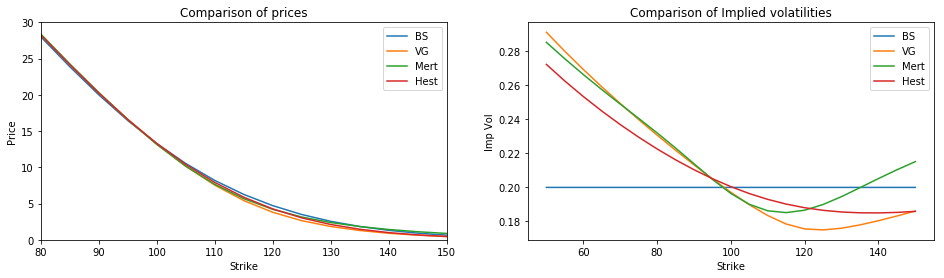

In [11]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.plot(strikes, BS_prices, label="BS"); ax1.plot(strikes, VG_prices, label="VG"); 
ax1.set_xlim([80,150]);ax1.set_ylim([0,30]) 
ax1.plot(strikes, Mert_prices, label="Mert"); ax1.plot(strikes, Hest_prices, label="Hest")
ax1.set_title("Comparison of prices"); ax1.set_xlabel("Strike"); ax1.set_ylabel("Price")
ax2.plot(strikes, IV_BS, label="BS"); ax2.plot(strikes, IV_VG, label="VG")
ax2.plot(strikes, IV_Mert, label="Mert"); ax2.plot(strikes, IV_Hest, label="Hest")
ax2.set_title("Comparison of Implied volatilities"); ax2.set_xlabel("Strike"); ax2.set_ylabel("Imp Vol")
ax1.legend(); ax2.legend(); plt.show()

#### Nice plot!  We verified that the Heston, Variance Gamma and Merton models produce a smile!!

<a id='sec1.2'></a>
##  Lewis representation


In [2], Gatheral suggests an elegant implicit expression for computing the implied volatility (Eq 5.7 page 60) generated by a stocastic process with characteristic function $\phi_T$.     
The expression makes use of the Lewis representation for the option price, that I presented in the notebook **1.4**. This version looks slightly different from Eq. 5.7 in [2], but they are equivalent. 

The value of $\sigma$ can be obtained implicitly from 

$$ 0 = \int_{0}^{\infty} Re \biggl[ e^{iuk} \bigg( \phi_T \big(u-\frac{i}{2} \big) - \phi^{BS}_T \big(u-\frac{i}{2} \big) \bigg) \biggr] \; \frac{1}{u^2 + \frac{1}{4}} du. $$

Replacing $\phi^{BS}_T(u) = e^{i(r-\frac{1}{2}\sigma^2) u T - \frac{1}{2} \sigma^2 u^2 T}$: 

$$ 0 = \int_{0}^{\infty} Re \biggl[ e^{iuk} \bigg( \phi_T \big(u-\frac{i}{2} \big) - 
e^{iurT} \, e^{\frac{1}{2}rT} \, e^{-\frac{1}{2}(u^2+\frac{1}{4})\sigma^2 T}
\bigg) \biggr] \; \frac{1}{u^2 + \frac{1}{4}} du. $$

The implementation of `IV_Lewis` is [here](./functions/FFT.py).

In [12]:
IV_L_BS = []; IV_L_VG = []; IV_L_Mert = []; IV_L_Hest = []
for K in strikes:
    BS.K = K; VG.K = K; Mert.K = K; Hest.K = K
    IV_L_BS.append( BS.IV_Lewis() )
    IV_L_VG.append( VG.IV_Lewis() )
    IV_L_Mert.append( Mert.IV_Lewis() )
    IV_L_Hest.append( Hest.IV_Lewis() )

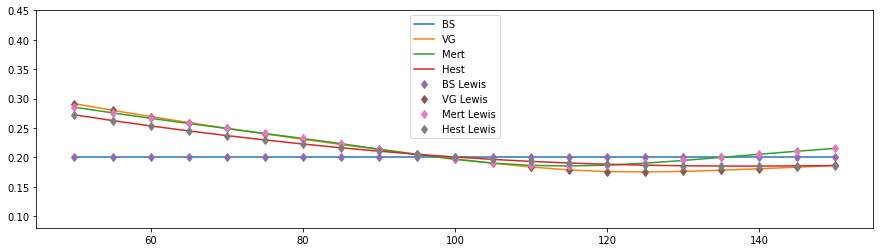

In [13]:
fig = plt.figure(figsize=(15,4))
plt.plot(strikes, IV_BS, label="BS"); plt.plot(strikes, IV_VG, label="VG")
plt.plot(strikes, IV_Mert, label="Mert"); plt.plot(strikes, IV_Hest, label="Hest")
plt.plot(strikes, IV_L_BS, 'd', label="BS Lewis"); plt.plot(strikes, IV_L_VG, 'd', label="VG Lewis")
plt.plot(strikes, IV_L_Mert, 'd', label="Mert Lewis"); plt.plot(strikes, IV_L_Hest, 'd', label="Hest Lewis")
plt.ylim([0.08, 0.45])
plt.legend(loc="upper center"); plt.show()

Ok, this method seems a bit slower than the previous, but it can be a good alternative.

<a id='sec2'></a>
# Market data


Let's analyze some options market data (the expiration dates were chosen at random). I took the following values from [barchart](https://www.barchart.com/etfs-funds/quotes/SPY/options?moneyness=allRows&expiration=2020-05-15-m).

The current date is 02 July 2020.

- Maturity date: 10 Aug 2020  $ \quad \quad \sim$ 1 week time to maturity.
- Maturity date: 15 Jan 2021  $\quad \quad \sim$ 1/2 year time to maturity

This is a set of option prices written on the [SPY](https://en.wikipedia.org/wiki/SPDR_S%26P_500_Trust_ETF) ETF. 
    
If we assume 252 business days, the time to maturity to the 10th of July corresponds to the year fraction 
$T = 5/252$, where 3, 4, and 5 July are holidays.     
For the 6 months maturity I'm using the Act-365 convention with $T=197/365$. Counting the year fraction considering only business days it is more common when dealing with options (see [4]) but in this case I have no idea how many holidays there are till the 15th of January. 

The current value of SPY is $S_0 = 312.23$.    

I didn't check the actual interest rate, and I will use a reasonable ad-hoc value. **This choice has a very important effect on the values of implied volatility.** In a serious analysis you should use the correct value of $r$ (which has a term structure dependent on T as well).

##### Comment:
For for very short times to maturity ($\sim$ days), it is very difficult to replicate the smile in the ITM and OTM regions. The reasons are several. There can be numerical error issues in the pricing and in the calibration process. Or more simply, the chosen stochastic model is not so good.

In [14]:
files = os.listdir(os.getcwd() + "/data")
print("Files in the data folder: ", files)

Files in the data folder:  ['spy-options-exp-2021-01-15-weekly-show-all-stacked-07-05-2020.csv', 'spy-options-exp-2020-07-10-weekly-show-all-stacked-07-05-2020.csv', 'historical_data.csv']


<a id='sec2.1'></a>
## 1 week maturity

In [15]:
S0 = 312.23
r = 0.05  
T = 5/252
opt_param = Option_param(S0=S0, K=S0, T=T, v0=0.04, exercise="European", payoff="call" )

In [16]:
filename = "data/" + "spy-options-exp-2020-07-10-weekly-show-all-stacked-07-05-2020.csv"
data = pd.read_csv(filename, usecols=[0,3,4,5,8,11])  
data["IV"] = data["IV"].str.rstrip('%').astype('float') / 100.0   # transforms the percentage into decimal
data["Spread"] = (data.Ask - data.Bid)   # spread column
data.tail()

,Strike,Bid,Midpoint,Ask,IV,Type,Spread
225,370,56.89,57.11,57.33,0.1387,Put,0.44
226,375,61.90,62.11,62.33,0.0025,Put,0.43
227,380,66.89,67.11,67.33,0.0000,Put,0.44
228,385,71.90,72.12,72.33,0.0000,Put,0.43
229,390,76.88,77.10,77.33,0.7404,Put,0.45


In [17]:
CALL = data[data.Type=="Call"]
PUT = data[data.Type=="Put"].reset_index(drop=True)

##### Let us recover the implied volatility from option prices.

We can check if the volatilities we computed correspond to the volatilities provided in the CSV file.    
For this purpose, we consider the Mid-price defined as the average between Bid and Ask prices. The error interval is the interval between Bid IV and Ask IV.

When working with this type of data, frequently happens that the CSV file contains unreliable values of IV:
1. because the solver was not able to converge.
2. because other operational errors.

Sometimes the problem is just the choice of using the Mid-price. Choosing another value between the Ask and the Bid price can yield a reliable value of the IV. In this case we can use `implied_vol_minimize`, which is able to reduce the error introduced by using the wrong price.     
In other cases, the error cannot be reduced and I think it is better to ignore those values.

#### Plots. Minimization:

In [18]:
IV_call = CALL.apply(lambda x: implied_vol_minimize(x['Midpoint'], S0, x['Strike'], T, r, payoff="call"), 
               axis=1)
CALL = CALL.assign(IV_mid=IV_call.values)
IV_put = PUT.apply(lambda x: implied_vol_minimize(x['Midpoint'], S0, x['Strike'], T, r, payoff="put", 
                                                  disp=False), axis=1)
PUT = PUT.assign(IV_mid=IV_put.values)

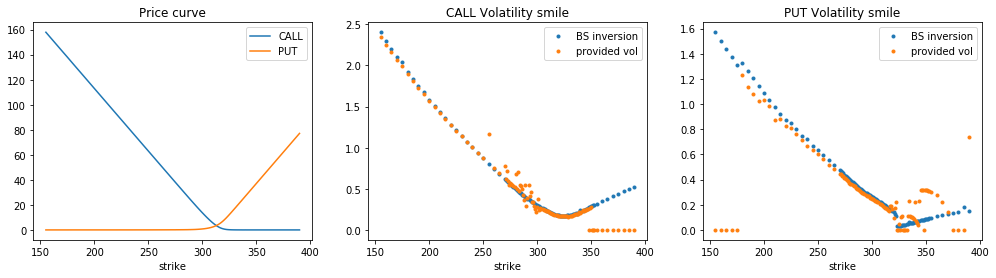

In [19]:
fig = plt.figure(figsize=(17,4))
ax1 = fig.add_subplot(131); ax2 = fig.add_subplot(132); ax3 = fig.add_subplot(133)
ax1.plot(CALL.Strike, CALL.Midpoint, '-', label="CALL")
ax1.plot(PUT.Strike, PUT.Midpoint, '-', label="PUT")
ax2.plot(CALL.Strike, CALL.IV_mid, '.', label="BS inversion")
ax2.plot(CALL.Strike, CALL.IV, '.', label="provided vol")
ax3.plot(PUT.Strike, PUT.IV_mid,'.', label="BS inversion")
ax3.plot(PUT.Strike, PUT.IV, '.', label="provided vol")
ax1.set_title("Price curve"); ax2.set_title("CALL Volatility smile"); ax3.set_title("PUT Volatility smile")
ax1.set_xlabel("strike"); ax2.set_xlabel("strike"); ax3.set_xlabel("strike")
ax1.legend(); ax2.legend(); ax3.legend(); plt.show()

#### Plots. Root finder:

In [20]:
IV_call = CALL.apply(lambda x: implied_volatility(x['Midpoint'], S0, x['Strike'], T, r, payoff="call", 
                                                  disp=False), axis=1)
CALL = CALL.assign(IV_mid=IV_call.values)
IV_put = PUT.apply(lambda x: implied_volatility(x['Midpoint'], S0, x['Strike'], T, r, payoff="put", disp=False),
                  axis=1)
PUT = PUT.assign(IV_mid=IV_put.values)

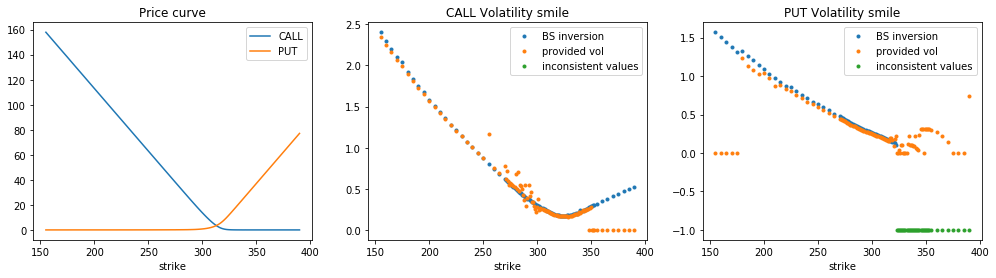

In [21]:
fig = plt.figure(figsize=(17,4))
ax1 = fig.add_subplot(131); ax2 = fig.add_subplot(132); ax3 = fig.add_subplot(133)
ax1.plot(CALL.Strike, CALL.Midpoint, '-', label="CALL")
ax1.plot(PUT.Strike, PUT.Midpoint, '-', label="PUT")
ax2.plot(CALL[CALL.IV_mid != -1].Strike, CALL[CALL.IV_mid != -1].IV_mid, '.', label="BS inversion")
ax2.plot(CALL.Strike, CALL.IV, '.', label="provided vol")
ax2.plot(CALL[CALL.IV_mid == -1].Strike, CALL[CALL.IV_mid == -1].IV_mid, '.', label="inconsistent values")
ax3.plot(PUT[PUT.IV_mid != -1].Strike, PUT[PUT.IV_mid != -1].IV_mid,'.', label="BS inversion")
ax3.plot(PUT.Strike, PUT.IV, '.', label="provided vol")
ax3.plot(PUT[PUT.IV_mid == -1].Strike, PUT[PUT.IV_mid == -1].IV_mid,'.', label="inconsistent values")
ax1.set_title("Price curve"); ax2.set_title("CALL Volatility smile"); ax3.set_title("PUT Volatility smile")
ax1.set_xlabel("strike"); ax2.set_xlabel("strike"); ax3.set_xlabel("strike")
ax1.legend(); ax2.legend(); ax3.legend(); plt.show()

**Inconsistent values:** when there is no implied volatility able to reproduce the mid-price, the `implied_volatility` function returns $-1$.  

Using `implied_vol_minimize` provide values for the put option that `implied_volatility` was not able to retrieve. However, it is difficult to say if these values are reliable or not.

Let use ignore the data point with $IV = -1$.

In [22]:
CALL = CALL[CALL.IV_mid != -1].reset_index(drop=True)
PUT = PUT[PUT.IV_mid != -1].reset_index(drop=True)

### Calibration

If we call $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:

$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$

where $P_i$ are the market prices, $f$ is the pricing function and $w_i$ are weights usually defined as 

$$ w_i = \frac{1}{\text{spread}_i} $$

(they give more importance to the points with smaller spread).

Among the many numerical methods, here I use the following:
- [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
    It uses the `trf` method when the parameters are bounded and the `Levemberg-Marquadt` method for unbounded parameters.
- [minimize(method=’SLSQP’)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp)

For the unconstrained problem (Heston, Merton and VG) I use `curve_fit`, while for the constrained Heston problem I use `minimize`.

##### Comment:
In order to make the code simpler, I will only use CALL prices for the calibration.

In [23]:
option_type = CALL
prices = option_type.Midpoint.values
strikes = option_type.Strike.values
spreads = option_type.Spread.values
payoff = "call"

##### Merton parameters calibration

In [24]:
def f_Mert(x, sig, lam, muJ, sigJ):
    Merton_param = Merton_process(r=r, sig=sig, lam=lam, muJ=muJ, sigJ=sigJ)
    opt_param = Option_param(S0=S0, K=x, T=T, v0=0.04, exercise="European", payoff="call" )
    Mert = Merton_pricer(opt_param, Merton_param)
    return Mert.closed_formula()

init_vals = [0.2, 1, -0.5, 0.2]
bounds=( [0, 0, -np.inf, 0], [2, np.inf, 5, 5] )
params_Mert = scpo.curve_fit(f_Mert, strikes, prices, p0=init_vals, bounds=bounds, sigma=spreads) 

##### VG parameters calibration

In [25]:
def f_VG(x, theta, sigma, kappa):
    VG_param = VG_process(r=r, theta=theta, sigma=sigma, kappa=kappa)
    opt_param = Option_param(S0=S0, K=K, T=T, v0=0.04, exercise="European", payoff="call" )
    VG = VG_pricer(opt_param, VG_param)
    return VG.FFT(x)

init_vals = [-0.05, 0.2, 0.1]
bounds=( [-np.inf, 0, 0], [np.inf, 5, np.inf] )
params_VG = scpo.curve_fit(f_VG, strikes, prices, p0=init_vals, bounds=bounds, sigma=spreads) 

##### Heston parameters calibration

What to do with the **Feller condition**?

The Feller condition is hardly satisfied in the market, mainly because having $\kappa \theta > \frac{1}{2} \sigma^2$ implies a high mean reversion which reduces the volatility of the stochastic volatility $\sigma^2$.    
The vol of vol is responsible for the convexity of the smile. 
In order to increase the convexity to match the empirical smile, we have to increase $\sigma^2$ violating the Feller condition.   
However this is not really an issue, at the moment the $v_t$ reaches $0$ we have a positive drift $dv_t = \kappa \theta dt$ that will push instantly the process away from 0.

Let us calibrate the two cases:
- Ignoring the Feller condition (using `curve_fit`).
- Introducing the Feller condition as an inequality constraint (using `minimize`).

#### Comment:
1. The calibration of the Heston pricing model is a difficult task and here I'm adopting a very naive approach.    
For more information I suggest you look at [3] where the problem is treated rigorously and there is also a literature review. 

2. The calibration of 5 parameters will make the following code **quite slow**. 
In [3] there are several suggestions to speed up the code.

In [26]:
# Unconstrained problem
def f_Hest(x, rho, sigma, theta, kappa, v0):
    Heston_param = Heston_process(mu=r, rho=rho, sigma=sigma, theta=theta, kappa=kappa)
    opt_param = Option_param(S0=S0, K=K, T=T, v0=v0, exercise="European", payoff=payoff )
    Hest = Heston_pricer(opt_param, Heston_param)
    return Hest.FFT(x)

init_vals = [-0.6, 1.0, 0.04, 2.5, 0.04]
bounds=( [-1, 1e-15, 1e-15, 1e-15, 1e-15], [1, np.inf, 2, np.inf, 2] )
params_Hest = scpo.curve_fit(f_Hest, strikes, prices, p0=init_vals, bounds=bounds, sigma=spreads,
                            xtol=1e-4, max_nfev=1000) 

In [27]:
## Constrained problem
init_vals = [-0.4, 1.1, 0.1, 0.6, 0.02]  # rho, sigma, theta, kappa, v0
#init_vals = [-0.7, 2.8, 0.7, 0.1, 0.02]  # alternative starting point

# bounds and constraint
bounds = ( (-1,1), (1e-15,np.inf), (1e-15, 50), (1e-15, 50), (1e-15, 10) )

def Feller(x):
    """ Feller condition """
    return 2*x[3] * x[2] - x[1]**2 - 1e-6
cons = ({"fun": Feller, "type": "ineq"})           # inequality constraint

def least_sq(x, prices, strikes, spread):
    """ Objective function """
    Heston_param = Heston_process(mu=r, rho=x[0], sigma=x[1], theta=x[2], kappa=x[3])
    opt_param = Option_param(S0=S0, K=K, T=T, v0=x[4], exercise="European", payoff="call" )
    Hest = Heston_pricer(opt_param, Heston_param)
    prices_calib = Hest.FFT(strikes)
    return np.sum( ((prices_calib - prices)/spread)**2 ) 
    
result = scpo.minimize(least_sq, x0=init_vals, args=(prices, strikes, spreads),
                  method='SLSQP', bounds=bounds,
                  constraints=cons, tol=1e-4, options={"maxiter":500})
print(result.message)

Optimization terminated successfully.


##### Now we can price the options using the just calibrated parameters.

In [28]:
opt_param_Feller = Option_param(S0=S0, K=K, T=T, v0=result.x[4], exercise="European", payoff=payoff )
opt_param = Option_param(S0=S0, K=K, T=T, v0=params_Hest[0][4], exercise="European", payoff=payoff )

Merton_param = Merton_process(r=r, sig=params_Mert[0][0], lam=params_Mert[0][1], 
                              muJ=params_Mert[0][2], sigJ=params_Mert[0][3])
Mert = Merton_pricer(opt_param, Merton_param)
VG_param = VG_process(r=r, theta=params_VG[0][0], sigma=params_VG[0][1], kappa=params_VG[0][2])
VG = VG_pricer(opt_param, VG_param)
Heston_param_Feller = Heston_process(mu=r, rho=result.x[0], sigma=result.x[1], 
                                     theta=result.x[2], kappa=result.x[3])
Heston_param = Heston_process(mu=r, rho=params_Hest[0][0], sigma=params_Hest[0][1], theta=params_Hest[0][2], 
                              kappa=params_Hest[0][3])
Hest = Heston_pricer(opt_param, Heston_param)
Hest_Feller = Heston_pricer(opt_param_Feller, Heston_param_Feller)

In [29]:
Mert_pred = Mert.FFT(strikes)          # "pred" stays for "predicted"
VG_pred = VG.FFT(strikes)
Hest_pred = Hest.FFT(strikes)
Hest_Feller_pred = Hest_Feller.FFT(strikes)

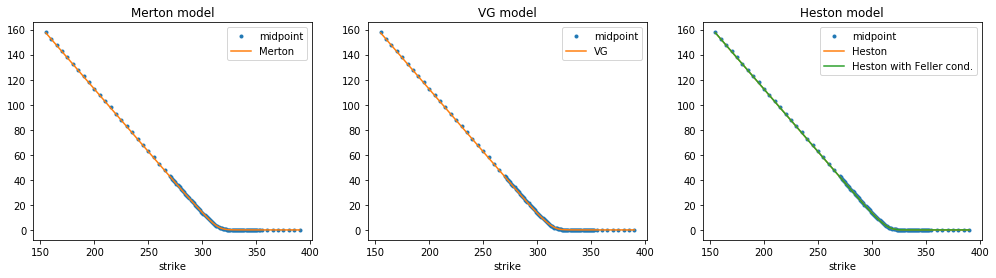

In [30]:
fig = plt.figure(figsize=(17,4))
ax1 = fig.add_subplot(131); ax2 = fig.add_subplot(132); ax3 = fig.add_subplot(133)
ax1.plot(strikes, prices,'.', label="midpoint")
ax2.plot(strikes, prices,'.', label="midpoint")
ax3.plot(strikes, prices,'.', label="midpoint")
ax1.plot(strikes, Mert_pred, label="Merton")
ax2.plot(strikes, VG_pred, label="VG")
ax3.plot(strikes, Hest_pred, label="Heston")
ax3.plot(strikes, Hest_Feller_pred, label="Heston with Feller cond.")
ax1.set_title("Merton model"); ax2.set_title("VG model"); ax3.set_title("Heston model")
ax1.set_xlabel("strike"); ax2.set_xlabel("strike"); ax3.set_xlabel("strike")
ax1.legend(); ax2.legend(); ax3.legend(); plt.show()

In [31]:
print("Are the values sorted? Merton: ", (np.diff(Mert_pred)<=0).all() if payoff=="call" 
      else (np.diff(Mert_pred)>=0).all() )
print("Are the values sorted? VG: ", (np.diff(VG_pred)<=0).all() if payoff=="call" 
      else (np.diff(VG_pred)>=0).all() )
print("Are the values sorted? Heston: ", (np.diff(Hest_pred)<=0).all() if payoff=="call" 
      else (np.diff(Hest_pred)>=0).all() )
print("Are the values sorted? Heston Feller: ", (np.diff(Hest_Feller_pred)<=0).all() if payoff=="call" 
      else (np.diff(Hest_Feller_pred)>=0).all() )
temp_list = list(compress(["VG", "Mert", "Hest", "Hest Feller"],
                [(VG_pred<0).any(), (Mert_pred<0).any(), (Hest_pred<0).any(), (Hest_Feller_pred<0).any()]) )
print("Negative values?", temp_list if len(temp_list)!=0 else "No" ) 

Are the values sorted? Merton:  True
Are the values sorted? VG:  False
Are the values sorted? Heston:  True
Are the values sorted? Heston Feller:  True
Negative values? ['VG', 'Hest Feller']


As already explained, the FFT method has problems for deep OTM values and short maturities. 
We can replace manually the negative values with fake values (we don't care too much about values with magnitude $\sim 10^{-8}$). 

In [32]:
Hest_Feller_pred[Hest_Feller_pred<0] = 1e-8
VG_pred[VG_pred<0] = 1e-8

Let us compare the errors of the used pricing models!

I choose MAV instead of MSE because I am only interested in the mean distance between the market price and the model price.

In [33]:
print("Merton. Mean absolute error: ", np.abs( prices - Mert_pred ).mean() )
print("VG. Mean absolute error: ", np.abs( prices - VG_pred ).mean() )
print("Heston. Mean absolute error: ",np.abs( prices - Hest_pred ).mean() )
print("Heston with Feller. Mean absolute error: ",np.abs( prices - Hest_Feller_pred ).mean() )

Merton. Mean absolute error:  0.16439607355767683
VG. Mean absolute error:  0.20894423405010518
Heston. Mean absolute error:  0.17674185214553964
Heston with Feller. Mean absolute error:  0.2253856273769932


Merton and Heston are the best, while the Heston with Feller condition is the worst.

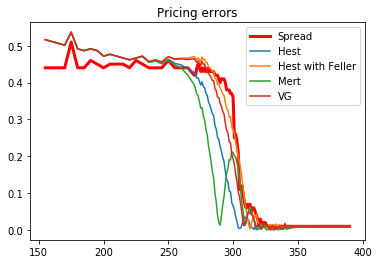

In [34]:
plt.plot(strikes, spreads, label="Spread", linewidth=3, color="red")
plt.plot(strikes, np.abs( prices - Hest_pred ), label="Hest")
plt.plot(strikes, np.abs( prices - Hest_Feller_pred ), label="Hest with Feller")
plt.plot(strikes, np.abs( prices - Mert_pred ), label="Mert")
plt.plot(strikes, np.abs( prices - VG_pred ), label="VG")
plt.title("Pricing errors"); plt.legend(); plt.show()

#### Implied volatility smile generated by the pricing models!

In [35]:
IV_VG = []; IV_Mert = []; IV_Hest = []; IV_Hest_F = []
for i,K in enumerate(strikes):
    IV_VG.append(implied_vol_minimize( VG_pred[i], S0=S0, K=K, T=T, r=r ) )
    IV_Mert.append(implied_vol_minimize( Mert_pred[i], S0=S0, K=K, T=T, r=r ) )
    IV_Hest.append(implied_vol_minimize( Hest_pred[i], S0=S0, K=K, T=T, r=r ) )
    IV_Hest_F.append(implied_vol_minimize( Hest_Feller_pred[i], S0=S0, K=K, T=T, r=r ) )

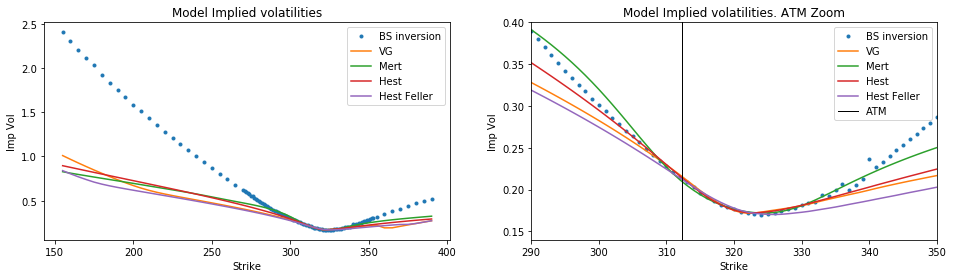

In [36]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.plot(strikes, option_type.IV_mid, '.', label="BS inversion")
ax2.plot(strikes, option_type.IV_mid, '.', label="BS inversion")
ax1.plot(strikes, IV_VG, label="VG"); ax2.plot(strikes, IV_VG, label="VG")
ax1.plot(strikes, IV_Mert, label="Mert"); ax2.plot(strikes, IV_Mert, label="Mert") 
ax1.plot(strikes, IV_Hest, label="Hest"); ax2.plot(strikes, IV_Hest, label="Hest")
ax1.plot(strikes, IV_Hest_F, label="Hest Feller"); ax2.plot(strikes, IV_Hest_F, label="Hest Feller")
ax2.axis([290,350,0.14,0.4]); ax2.axvline(S0, color="black", label="ATM", linewidth=1)
ax2.set_title("Model Implied volatilities. ATM Zoom"); ax1.set_xlabel("Strike"); ax1.set_ylabel("Imp Vol")
ax1.set_title("Model Implied volatilities"); ax2.set_xlabel("Strike"); ax2.set_ylabel("Imp Vol")
ax1.legend(); ax2.legend(); plt.show()

The pricing models produce a good fit in the neighborhood of the ATM region.

In this region, the Merton model is the best.

#### Comment:
As expected the Heston model with NO Feller condition provides much better results.

<a id='sec2.2'></a>
# 6 months maturity


Now let's go over the steps taken before and calculate the volatility smile for options with a maturity of 6 months.

Sorry. The code will be a little repetitive.

In [37]:
S0 = 312.23
r = 0.015
T = 197/365  
opt_param = Option_param(S0=S0, K=S0, T=T, v0=0.04, exercise="European", payoff="call" )

In [38]:
filename = "data/" + "spy-options-exp-2021-01-15-weekly-show-all-stacked-07-05-2020.csv"
data = pd.read_csv(filename, usecols=[1,4,5,6,9,12])
data["IV"] = data["IV"].str.rstrip('%').astype('float') / 100.0   # transforms the percentage into decimal
data["Spread"] = (data.Ask - data.Bid)   # spread column
data.tail()

,Strike,Bid,Midpoint,Ask,IV,Type,Spread
499,535,223.36,223.98,224.59,0.5099,Put,1.23
500,540,228.35,228.97,229.58,0.5168,Put,1.23
501,545,233.33,233.95,234.56,0.5233,Put,1.23
502,550,238.32,238.94,239.55,0.5301,Put,1.23
503,555,243.31,243.93,244.54,0.5368,Put,1.23


In [39]:
CALL = data[data.Type=="Call"]
PUT = data[data.Type=="Put"].reset_index(drop=True)

#### Plots, root finder:

In [40]:
IV_call = CALL.apply(lambda x: implied_volatility(x['Midpoint'], S0, x['Strike'], T, r, payoff="call", 
                                                  disp=False), axis=1)
CALL = CALL.assign(IV_mid=IV_call.values)
IV_put = PUT.apply(lambda x: implied_volatility(x['Midpoint'], S0, x['Strike'], T, r, payoff="put", disp=False),
                  axis=1)
PUT = PUT.assign(IV_mid=IV_put.values)

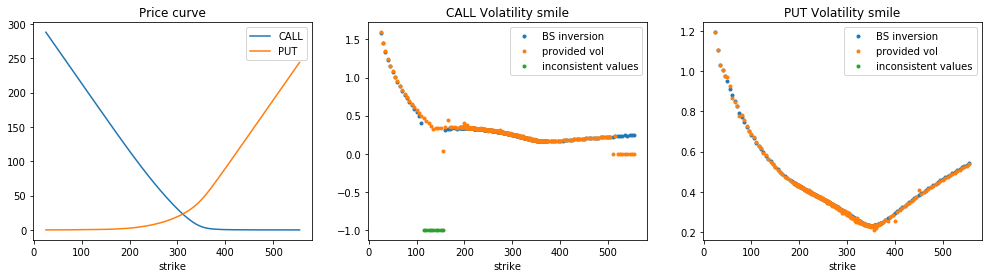

In [41]:
fig = plt.figure(figsize=(17,4))
ax1 = fig.add_subplot(131); ax2 = fig.add_subplot(132); ax3 = fig.add_subplot(133)
ax1.plot(CALL.Strike, CALL.Midpoint, '-', label="CALL")
ax1.plot(PUT.Strike, PUT.Midpoint, '-', label="PUT")
ax2.plot(CALL[CALL.IV_mid != -1].Strike, CALL[CALL.IV_mid != -1].IV_mid, '.', label="BS inversion")
ax2.plot(CALL.Strike, CALL.IV, '.', label="provided vol")
ax2.plot(CALL[CALL.IV_mid == -1].Strike, CALL[CALL.IV_mid == -1].IV_mid, '.', label="inconsistent values")
ax3.plot(PUT[PUT.IV_mid != -1].Strike, PUT[PUT.IV_mid != -1].IV_mid,'.', label="BS inversion")
ax3.plot(PUT.Strike, PUT.IV, '.', label="provided vol")
ax3.plot(PUT[PUT.IV_mid == -1].Strike, PUT[PUT.IV_mid == -1].IV_mid,'.', label="inconsistent values")
ax1.set_title("Price curve"); ax2.set_title("CALL Volatility smile"); ax3.set_title("PUT Volatility smile")
ax1.set_xlabel("strike"); ax2.set_xlabel("strike"); ax3.set_xlabel("strike")
ax1.legend(); ax2.legend(); ax3.legend(); plt.show()

In [42]:
CALL = CALL[CALL.IV_mid != -1].reset_index(drop=True)
PUT = PUT[PUT.IV_mid != -1].reset_index(drop=True)

### Calibration

Since we found that the Feller condition is not satisfied, I consider only the unconstrained problem.

In [43]:
option_type = CALL
prices = option_type.Midpoint.values
strikes = option_type.Strike.values
spreads = option_type.Spread.values
payoff = "call"

In [44]:
def f_Mert(x, sig, lam, muJ, sigJ):
    Merton_param = Merton_process(r=r, sig=sig, lam=lam, muJ=muJ, sigJ=sigJ)
    opt_param = Option_param(S0=S0, K=x, T=T, v0=0.04, exercise="European", payoff=payoff )
    Mert = Merton_pricer(opt_param, Merton_param)
    return Mert.closed_formula()

init_vals = [0.2, 1, -0.5, 0.2]
bounds=( [0, 0, -np.inf, 0], [2, np.inf, 5, 5] )
params_Mert = scpo.curve_fit(f_Mert, strikes, prices, p0=init_vals, bounds=bounds, sigma=spreads) 

In [45]:
def f_VG(x, theta, sigma, kappa):
    VG_param = VG_process(r=r, theta=theta, sigma=sigma, kappa=kappa)
    opt_param = Option_param(S0=S0, K=K, T=T, v0=0.04, exercise="European", payoff=payoff )
    VG = VG_pricer(opt_param, VG_param)
    return VG.FFT(x)

init_vals = [-0.05, 0.2, 0.1]
bounds=( [-np.inf, 0, 0], [np.inf, 5, np.inf] )
params_VG = scpo.curve_fit(f_VG, strikes, prices, p0=init_vals, bounds=bounds, sigma=spreads) 

In [46]:
def f_Hest(x, rho, sigma, theta, kappa, v0):
    Heston_param = Heston_process(mu=r, rho=rho, sigma=sigma, theta=theta, kappa=kappa)
    opt_param = Option_param(S0=S0, K=K, T=T, v0=v0, exercise="European", payoff=payoff )
    Hest = Heston_pricer(opt_param, Heston_param)
    return Hest.FFT(x)

init_vals = [-0.6, 0.1, 0.04, 10, 0.01]
bounds=( [-1, 1e-15, 1e-15, 1e-15, 1e-15], [1, np.inf, 2, np.inf, 2] )
params_Hest = scpo.curve_fit(f_Hest, strikes, prices, p0=init_vals, bounds=bounds, sigma=spreads)

##### Now we can price the options using the just calibrated parameters.

In [47]:
opt_param = Option_param(S0=S0, K=K, T=T, v0=params_Hest[0][4], exercise="European", payoff=payoff )
Merton_param = Merton_process(r=r, sig=params_Mert[0][0], lam=params_Mert[0][1], 
                              muJ=params_Mert[0][2], sigJ=params_Mert[0][3])
Mert = Merton_pricer(opt_param, Merton_param)
VG_param = VG_process(r=r, theta=params_VG[0][0], sigma=params_VG[0][1], kappa=params_VG[0][2])
VG = VG_pricer(opt_param, VG_param)
Heston_param = Heston_process(mu=r, rho=params_Hest[0][0], sigma=params_Hest[0][1], theta=params_Hest[0][2], 
                              kappa=params_Hest[0][3])
Hest = Heston_pricer(opt_param, Heston_param)

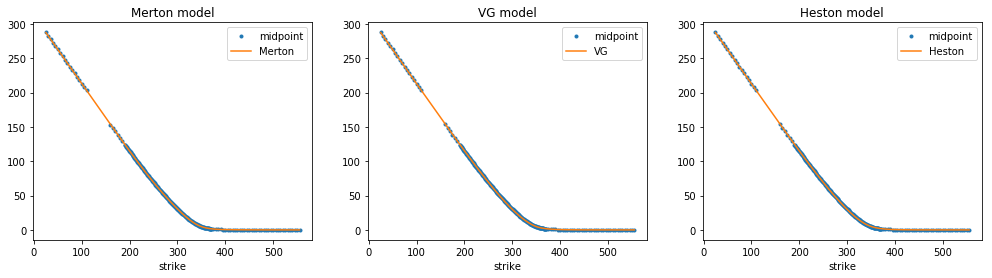

In [48]:
fig = plt.figure(figsize=(17,4))
ax1 = fig.add_subplot(131); ax2 = fig.add_subplot(132); ax3 = fig.add_subplot(133)
ax1.plot(strikes, prices,'.', label="midpoint")
ax2.plot(strikes, prices,'.', label="midpoint")
ax3.plot(strikes, prices,'.', label="midpoint")
ax1.plot(strikes, Mert.FFT(strikes), label="Merton")
ax2.plot(strikes, VG.FFT(strikes), label="VG")
ax3.plot(strikes, Hest.FFT(strikes), label="Heston")
ax1.set_title("Merton model"); ax2.set_title("VG model"); ax3.set_title("Heston model")
ax1.set_xlabel("strike"); ax2.set_xlabel("strike"); ax3.set_xlabel("strike")
ax1.legend(); ax2.legend(); ax3.legend(); plt.show()

In [49]:
Mert_pred = Mert.FFT(strikes)
VG_pred = VG.FFT(strikes)
Hest_pred = Hest.FFT(strikes)

In [50]:
print("Are the values sorted? Mert: ", (np.diff(Mert_pred)<=0).all() if payoff=="call" 
      else (np.diff(Mert_pred)>=0).all() )
print("Are the values sorted? VG: ", (np.diff(VG_pred)<=0).all() if payoff=="call" 
      else (np.diff(VG_pred)>=0).all() )
print("Are the values sorted? Hest: ", (np.diff(Hest_pred)<=0).all() if payoff=="call" 
      else (np.diff(Hest_pred)>=0).all() )
temp_list = list(compress(["VG", "Mert", "Hest"],[(VG_pred<0).any(), (Mert_pred<0).any(), (Hest_pred<0).any()]) )
print("Negative values?", temp_list if len(temp_list)!=0 else "No" ) 

Are the values sorted? Mert:  True
Are the values sorted? VG:  True
Are the values sorted? Hest:  True
Negative values? No


##### Errors

In [51]:
print("Merton. Mean absolute error: ", np.abs( prices - Mert_pred ).mean() )
print("VG. Mean absolute error: ", np.abs( prices - VG_pred ).mean() )
print("Heston. Mean absolute error: ",np.abs( prices - Hest_pred ).mean() )

Merton. Mean absolute error:  0.08542792018656539
VG. Mean absolute error:  0.26298353895417736
Heston. Mean absolute error:  0.29792561936921413


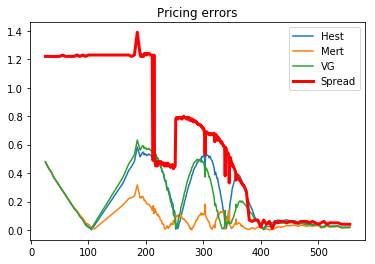

In [52]:
plt.plot(strikes, np.abs( prices - Hest_pred ), label="Hest")
plt.plot(strikes, np.abs( prices - Mert_pred ), label="Mert")
plt.plot(strikes, np.abs( prices - VG_pred ), label="VG")
plt.plot(strikes, spreads, label="Spread", linewidth=3, color="red")
plt.title("Pricing errors"); plt.legend(); plt.show()

In [53]:
IV_VG = []; IV_Mert = []; IV_Hest = []
for i,K in enumerate(CALL.Strike.values):
    IV_VG.append(implied_vol_minimize( VG_pred[i], S0=S0, K=K, T=T, r=r ) )
    IV_Mert.append(implied_vol_minimize( Mert_pred[i], S0=S0, K=K, T=T, r=r ) )
    IV_Hest.append(implied_vol_minimize( Hest_pred[i], S0=S0, K=K, T=T, r=r ) )

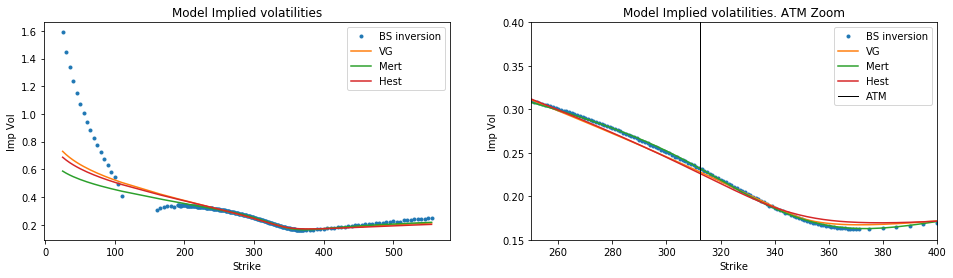

In [54]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.plot(strikes, option_type.IV_mid, '.', label="BS inversion")
ax2.plot(strikes, option_type.IV_mid, '.', label="BS inversion")
ax1.plot(strikes, IV_VG, label="VG"); ax2.plot(strikes, IV_VG, label="VG")
ax1.plot(strikes, IV_Mert, label="Mert"); ax2.plot(strikes, IV_Mert, label="Mert") 
ax1.plot(strikes, IV_Hest, label="Hest"); ax2.plot(strikes, IV_Hest, label="Hest")
ax2.axis([250,400,0.15,0.4]); ax2.axvline(S0, color="black", label="ATM", linewidth=1)
ax2.set_title("Model Implied volatilities. ATM Zoom"); ax1.set_xlabel("Strike"); ax1.set_ylabel("Imp Vol")
ax1.set_title("Model Implied volatilities"); ax2.set_xlabel("Strike"); ax2.set_ylabel("Imp Vol")
ax1.legend(); ax2.legend(); plt.show()

Again the Merton model is the model that performs better.

## References

[1] Rebonato, R. (1999) "Volatility and Correlation: In the Pricing of Equity, FX and Interest-Rate Options", Wiley Series in Financial Engineering.

[2] Gatheral, J. (2006) "The Volatility Surface: A Practitioner’s Guide (Wiley Finance Series)", John Wiley & Sons, New York.

[3] Yiran Cui, Sebastian del Baño Rollin, Guido Germano, (2017), "Full and fast calibration of the Heston stochastic volatility model" European Journal of operational research. [link](http://www0.cs.ucl.ac.uk/staff/g.germano/papers/EurJOperRes_2017.pdf)

[4] John Hull. "Options, Futures, and Other Derivatives".